In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import string
import json
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from textblob import TextBlob
from wordcloud import WordCloud

In [9]:
news = pd.read_csv('CBRS_container/data/mind/MINDsmall_train/news.tsv', header=None, sep='\t')
news.columns = ['article_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']
news.head()

article_id   category      subcategory  \
0     N55528  lifestyle  lifestyleroyals   
1     N19639     health       weightloss   
2     N61837       news        newsworld   
3     N53526     health           voices   
4     N38324     health          medical   

                                               title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1                      50 Worst Habits For Belly Fat   
2  The Cost of Trump's Aid Freeze in the Trenches...   
3  I Was An NBA Wife. Here's How It Affected My M...   
4  How to Get Rid of Skin Tags, According to a De...   

                                            abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  These seemingly harmless habits are holding yo...   
2  Lt. Ivan Molchanets peeked over a parapet of s...   
3  I felt like I was a fraud, and being an NBA wi...   
4  They seem harmless, but there's a very good re...   

                                             url  \
0  https://assets.msn.com/labs/mind/AAGH0ET.html   
1  https://assets.msn.com/labs/mind/AAB19MK.html   
2  https://assets.msn.com/labs/mind/AAJgNsz.html   
3  https://assets.msn.com/labs/mind/AACk2N6.html   
4  https://assets.msn.com/labs/mind/AAAKEkt.html   

                                      title_entities  \
0  [{"Label": "Prince Philip, Duke of Edinburgh",...   
1  [{"Label": "Adipose tissue", "Type": "C", "Wik...   
2                                                 []   
3                                                 []   
4  [{"Label": "Skin tag", "Type": "C", "WikidataI...   

                                   abstract_entities  
0                                                 []  
1  [{"Label": "Adipose tissue", "Type": "C", "Wik...  
2  [{"Label": "Ukraine", "Type": "G", "WikidataId...  
3  [{"Label": "National Basketball Association", ...  
4  [{"Label": "Skin tag", "Type": "C", "WikidataI...

In [11]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_id         51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [12]:
news.isna().sum()

article_id              0
category                0
subcategory             0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64

In [14]:
# check that IDs are unique
news.duplicated('article_id').sum()

0

In [15]:
# titles are not unique
news.duplicated('title').sum()

848

In [16]:
# titles are not unique
news.duplicated('abstract').sum()

3972

In [18]:
# Number of categories
news['category'].nunique()

17

In [31]:
# Number of articles per category
news.groupby('category')['subcategory'].count().sort_values(ascending=False)

category
news             15774
sports           14510
finance           3107
foodanddrink      2551
lifestyle         2479
travel            2350
video             2068
weather           2048
health            1885
autos             1639
tv                 889
music              769
movies             606
entertainment      587
kids                17
middleeast           2
northamerica         1
Name: subcategory, dtype: int64

In [32]:
# Number of subcategories
news['subcategory'].nunique()

264

In [27]:
# Top 10 overall subcategories
news.groupby('subcategory')['title'].count().sort_values(ascending=False).nlargest(20)

subcategory
newsus                      6564
football_nfl                5420
newspolitics                2826
newscrime                   2254
weathertopstories           2047
newsworld                   1720
football_ncaa               1665
baseball_mlb                1661
basketball_nba              1555
newsscienceandtechnology    1210
news                        1185
newstrends                  1176
more_sports                 1065
travelarticle               1042
travelnews                   902
lifestylebuzz                894
autosnews                    837
basketball_ncaa              774
financenews                  697
finance-real-estate          584
Name: title, dtype: int64

In [35]:
# Get the categories in order of popularity
category_order = [x for x, count in sorted(Counter(news['category']).items(), key=lambda x: -x[1])]

# Create a DataFrame with category counts
category_counts = news['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
category_counts = category_counts.sort_values('category', key=lambda x: [category_order.index(c) for c in x])

# Create the count plot using Plotly
fig = px.bar(category_counts, x='category', y='count', title='Category Counts')
fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': category_order})

# Display the plot
fig.show()

In [37]:
	
c=news[['category','subcategory']].value_counts()

index=[]
for i in c.index:
    index.append(np.array(i))
index=np.array(index)

distribution_df=pd.DataFrame(columns=['category','subcategory','values'])
distribution_df['category']=index[:,0]
distribution_df['subcategory']=index[:,1]
distribution_df['values']=c.values

px.bar(data_frame=distribution_df,x='category',y='values',color='subcategory')

In [41]:
# top 5 most popular subcategories for each of the top 5 categories
top_categories = news['category'].value_counts().nlargest(5).index

# Generate count plots for subcategories within each top category
for category in top_categories:
    subcategory_counts = news[news['category'] == category]['subcategory'].value_counts().nlargest(10)
    fig = px.bar(subcategory_counts, x=subcategory_counts.index, y=subcategory_counts.values,
                 labels={'x': 'subcategory', 'y': 'Count'}, title=f"Subcategories for {category}")
    fig.update_xaxes(tickangle=50)
    fig.show()

In [43]:
# Top 5 words in each category

from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Group the data by category
grouped = news.groupby('category')

# Iterate over each category
for category, group in grouped:
    titles = ' '.join(group['title'])  # Concatenate all titles for the category
    words = titles.split()  # Split the concatenated titles into individual words

    # Remove stopwords from the list of words
    words = [word.strip(' "\'') for word in words if word.lower() not in stop_words and word != '-']

    word_counts = Counter(words)  # Count the occurrences of each word

    # Find the top 5 most common words
    top_words = word_counts.most_common(5)

    print(f"{category}:")
    for word, count in top_words:
        print(f"{word} ({count})")
    print()

autos:
2020 (174)
crash (153)
Ford (97)
Car (97)
New (74)

entertainment:
2019 (73)
news (37)
Halloween (34)
plus (33)
Stars (29)

finance:
new (104)
US (86)
says (78)
million (76)
Microsoft (73)

foodanddrink:
Thanksgiving (209)
Recipes (167)
New (165)
Best (139)
Make (124)

health:
Weight (76)
Here's (71)
Health (70)
Pounds (58)
cancer (56)

kids:
Here's (2)
White (2)
Americans (1)
Use (1)
Fahrenheit (1)

lifestyle:
Halloween (88)
Best (87)
Meghan (86)
Prince (80)
Things (63)

middleeast:
killing (2)
Saudi (1)
says (1)
Baghdadi (1)
distorted (1)

movies:
Trailer (73)
Jennifer (28)
The (28)
Movie (21)
John (19)

music:
Awards (48)
2019 (47)
New (46)
CMA (40)
Music (39)

news:
Trump (1177)
police (564)
says (557)
Man (553)
man (518)

northamerica:
Republicans (1)
floated (1)
17 (1)
different (1)
defenses (1)

sports:
vs. (745)
Week (743)
win (650)
NFL (551)
State (480)

travel:
New (112)
new (80)
Best (75)
Day (59)
best (57)

tv:
TV (63)
The (42)
Says (33)
New (30)
Joe (25)

video:
Tru

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soniaborsi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Top 5 words bi grams in each category

from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Group the data by category
grouped = news.groupby('category')

# Iterate over each category
for category, group in grouped:
    titles = ' '.join(group['title'])  # Concatenate all titles for the category
    words = titles.split()  # Split the concatenated titles into individual words

    # Remove stopwords from the list of words
    words = [word.strip(' "\'') for word in words if word.lower() not in stop_words and word != '-']

    # Generate bi-grams
    bi_grams = list(nltk.bigrams(words))

    bi_gram_counts = Counter(bi_grams)  # Count the occurrences of each bi-gram

    # Find the top 5 most common bi-grams
    top_bi_grams = bi_gram_counts.most_common(5)

    print(f"{category}:")
    for bi_gram, count in top_bi_grams:
        print(f"{' '.join(bi_gram)} ({count})")
    print()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soniaborsi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


autos:
Ford Mustang (23)
2020 Ford (19)
Mustang Shelby (13)
Shelby GT500 (13)
crash involving (13)

entertainment:
plus news (24)
People's Choice (22)
Choice Awards (16)
Kylie Jenner (9)
2019 People's (8)

finance:
Apartments rent (42)
get you? (42)
Social Security (18)
737 Max (17)
right now? (14)

foodanddrink:
Thanksgiving Recipes (26)
Every State (23)
Thanksgiving Dinner (21)
Veterans Day (19)
Trader Joe's (18)

health:
Weight Loss (29)
Lose Weight (19)
Breast Cancer (18)
breast cancer (13)
Need Know (11)

kids:
Americans Use (1)
Use Fahrenheit (1)
Fahrenheit Instead (1)
Instead Celsius (1)
Celsius Take (1)

lifestyle:
Meghan Markle (57)
Kate Middleton (34)
Prince Harry (31)
Veterans Day (19)
Zodiac Sign (16)

middleeast:
Saudi says (1)
says Baghdadi (1)
Baghdadi distorted (1)
distorted image (1)
image Islam, (1)

movies:
Jennifer Aniston (11)
Box Office (10)
Kevin Hart (9)
Charlize Theron (9)
Star Wars (8)

music:
CMA Awards (29)
Taylor Swift (22)
Kanye West (16)
Elton John (15)
C

In [47]:
# top 10 most popular titles
news['title'].value_counts().nlargest(10)

title
Photos of the Day                                                               15
Look of the Day                                                                 14
Friday's Scores                                                                  8
Video appears to show Astros stealing signs against Danny Farquhar               6
Winter already? Snow, deep freeze from Rockies to East Coast                     5
Morning news briefing from CNN                                                   5
Yu Darvish sends hilarious tweet about Astros cheating scandal                   5
Sunday Real Estate: 3 Luxurious Florida Homes                                    5
Microsoft vows to 'honor' California's sweeping privacy law across entire US     5
This company will pay you $1,000 to watch Hallmark Christmas movies              5
Name: count, dtype: int64

In [48]:
# analyzing titles
df_word_count = news.copy()

# title polarity
df_word_count['title_polarity'] = df_word_count['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

# word_count
df_word_count['title_word_count'] = df_word_count['title'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_word_count['title_unique_word_count'] = df_word_count['title'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_word_count['title_stop_word_count'] = df_word_count['title'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))

# mean_word_length
df_word_count['title_mean_word_length'] = df_word_count['title'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_word_count['title_char_count'] = df_word_count['title'].apply(lambda x: len(str(x)))

# punctuation_count
df_word_count['title_punctuation_count'] = df_word_count['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [49]:
# Select columns to make histograms for
columns = ['title_polarity', 'title_word_count', 'title_unique_word_count', 'title_stop_word_count',
           'title_mean_word_length', 'title_char_count', 'title_punctuation_count']

# Create subplots using make_subplots
num_subplots = len(columns)
fig = make_subplots(rows=num_subplots, cols=1, subplot_titles=columns, row_heights=[5] * num_subplots)

# Create histograms for each column
for i, column in enumerate(columns, start=1):
    fig.add_trace(go.Histogram(x=df_word_count[column], nbinsx=100), row=i, col=1)

# Update the layout of subplots
fig.update_layout(height=1000, width=800, showlegend=False)

# Display the plot
fig.show()

In [50]:
# word count per category
df_word_count_grouped = df_word_count.groupby('category')['title_word_count'].mean().reset_index().sort_values(by='title_word_count', ascending=False)

fig = px.bar(df_word_count_grouped, x='category', y='title_word_count')
fig.show()

In [51]:
# average polarity per category
df_word_count_grouped = df_word_count.groupby('category')['title_polarity'].mean().reset_index().sort_values(by='title_polarity', ascending=False)

fig = px.bar(df_word_count_grouped, x='category', y='title_polarity')
fig.show()

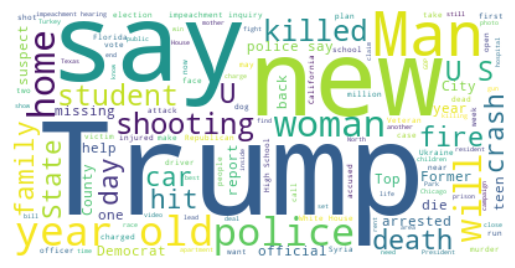

In [54]:
# news category
text=' '
for i in news[news['category']=='news']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

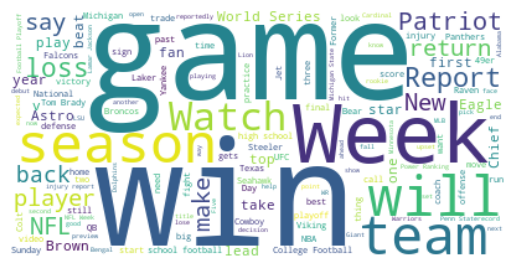

In [55]:
# sports category
text=' '
for i in news[news['category']=='sports']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

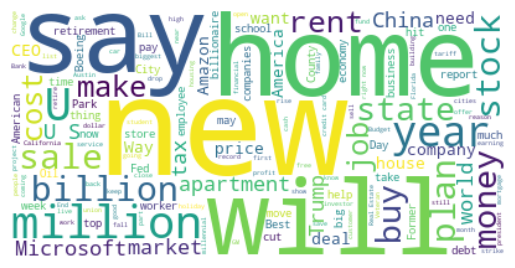

In [56]:
# finance category
text=' '
for i in news[news['category']=='finance']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [57]:
# define function to extract any metric from any of the entities columns

def entities(df, col_number, metric):
    entities = df.iloc[:, col_number]
    entities = entities.dropna()

    labels = []

    for entity in entities:
        entity = json.loads(entity)

        for dictionary in entity:
            labels.append(dictionary[metric])

    return labels

In [59]:
title_labels = entities(news, 6, 'Label')

In [60]:
	
# find 10 most and least popular labels
title_label_counter = Counter(title_labels)

bottom_10_title_labels = title_label_counter.most_common()[::-1][:10]
top_10_title_labels = title_label_counter.most_common(10)

In [61]:
top_10_title_labels

[('Donald Trump', 1501),
 ('National Football League', 510),
 ('United States', 398),
 ('New England Patriots', 392),
 ('Houston Astros', 369),
 ('California', 339),
 ('Republican Party (United States)', 289),
 ('Democratic Party (United States)', 273),
 ('Florida', 265),
 ('Ukraine', 263)]

In [63]:
bottom_10_title_labels

[('Peugeot RCZ', 1),
 ('Realme', 1),
 ('Dayton–Wright Brothers Airport', 1),
 ('Turkish Land Forces', 1),
 ('High-stakes testing', 1),
 ('Bright spots on Ceres', 1),
 ('Brick Store Museum', 1),
 ('Hickory, North Carolina', 1),
 ('North Carolina Department of Public Safety', 1),
 ('Jeffersontown, Kentucky', 1)]

In [ ]:
df_behaviors = pd.read_csv("CBRS_container/data/mind/MINDsmall_train/behaviors.tsv", header=None, sep='\t')
df_behaviors.columns = ['impression_id', 'user_id', 'timestamp', 'history', 'impressions']

In [65]:
df_behaviors.head()

impression_id user_id              timestamp  \
0              1  U13740  11/11/2019 9:05:58 AM   
1              2  U91836  11/12/2019 6:11:30 PM   
2              3  U73700  11/14/2019 7:01:48 AM   
3              4  U34670  11/11/2019 5:28:05 AM   
4              5   U8125  11/12/2019 4:11:21 PM   

                                             history  \
0  N55189 N42782 N34694 N45794 N18445 N63302 N104...   
1  N31739 N6072 N63045 N23979 N35656 N43353 N8129...   
2  N10732 N25792 N7563 N21087 N41087 N5445 N60384...   
3  N45729 N2203 N871 N53880 N41375 N43142 N33013 ...   
4                        N10078 N56514 N14904 N33740   

                                         impressions  
0                                  N55689-1 N35729-0  
1  N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...  
2  N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...  
3                N35729-0 N33632-0 N49685-1 N27581-0  
4  N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...

In [66]:
df_behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   impression_id  156965 non-null  int64 
 1   user_id        156965 non-null  object
 2   timestamp      156965 non-null  object
 3   history        153727 non-null  object
 4   impressions    156965 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [67]:
# convert timestamp to date time
df_behaviors['timestamp'] = pd.to_datetime(df_behaviors['timestamp'])

In [68]:
print(df_behaviors['timestamp'].min())
print(df_behaviors['timestamp'].max())

2019-11-09 00:00:19
2019-11-14 23:59:13


In [69]:
# unique number of user IDs
df_behaviors['user_id'].nunique()

50000

In [70]:
# unique number of histories
df_behaviors['history'].nunique()

48868

In [71]:
df_behaviors.isna().sum()

impression_id       0
user_id             0
timestamp           0
history          3238
impressions         0
dtype: int64